In [1]:
#imports
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from scipy.sparse.linalg import svds

from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from nltk.corpus import stopwords 
import string
from nltk.tokenize import WordPunctTokenizer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [2]:
df=pd.read_csv("capstone_project_dataset.csv")

In [3]:
df

,Unnamed: 0,User ID,City,User Longitude,User Latitude,Resturant Name,Resturant Longitude,Resturant Latitude,Categories,Special Diets,Review Score,Comments
0,0,317,Jeddah,39.218564,21.736983,Al-Saaj Al-Reefi,39.137253,21.621797,"Fast Food, Middle Eastern, Lebanese, Mediterra...",Non,4.0,Wow... Loved this place
1,1,415,Riyadh,46.937884,24.551856,Lusin,46.683451,24.697821,"Mediterranean, Middle Eastern, Armenian","Vegetarian Friendly, Vegan Options, Gluten Fre...",4.6,Crust is not good.
2,2,425,Riyadh,46.501978,24.699156,La Brasserie,46.684105,24.690431,"French, International","Vegetarian Friendly, Vegan Options",2.7,Not tasty and the texture was just nasty.
3,3,456,Eastern Province,52.528577,26.575229,Manoosha Alreef,50.118295,26.445350,"Lebanese, Fast Food, Mediterranean, Middle Eas...","Vegetarian Friendly, Vegan Options",4.7,Stopped by during the late May bank holiday of...
4,4,420,Eastern Province,53.446234,26.122919,Queen Of India,50.179829,26.328298,Indian,"Vegetarian Friendly, Vegan Options, Gluten Fre...",4.9,The selection on the menu was great and so wer...
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,166,Jeddah,39.304262,21.655744,Aromi,39.109269,21.603596,"Italian, Mediterranean, European","Vegetarian Friendly, Vegan Options, Gluten Fre...",2.8,I can't tell you how disappointed I was.
996,996,293,Eastern Province,51.736019,21.813979,Tandoori House,50.129764,26.303790,Indian,Non,4.6,I think food should have flavor and texture an...
997,997,247,Eastern Province,55.466600,22.179759,Al-Sanbok Restaurant,50.220734,26.271833,"Seafood, International, Mediterranean","Vegetarian Friendly, Vegan Options, Gluten Fre...",4.2,Appetite instantly gone.
998,998,31,Riyadh,46.847037,24.553088,Al Orjouan,46.630201,24.665121,"Mediterranean, Middle Eastern, International","Vegetarian Friendly, Vegan Options, Gluten Fre...",3.6,Overall I was not impressed and would not go b...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           1000 non-null   int64  
 1   User ID              1000 non-null   int64  
 2   City                 1000 non-null   object 
 3   User Longitude       1000 non-null   float64
 4   User Latitude        1000 non-null   float64
 5   Resturant Name       1000 non-null   object 
 6   Resturant Longitude  1000 non-null   float64
 7   Resturant Latitude   1000 non-null   float64
 8   Categories           1000 non-null   object 
 9   Special Diets        1000 non-null   object 
 10  Review Score         1000 non-null   float64
 11  Comments             1000 non-null   object 
dtypes: float64(5), int64(2), object(5)
memory usage: 93.9+ KB


In [5]:
df['Comments'].head()

0                              Wow... Loved this place
1                                   Crust is not good.
2            Not tasty and the texture was just nasty.
3    Stopped by during the late May bank holiday of...
4    The selection on the menu was great and so wer...
Name: Comments, dtype: object

In [6]:
# Filtering for negative reviews (one and two star)

one_star_reviews = df[df['Review Score'] < 2.0]
two_star_reviews = df[(df['Review Score'] >= 2.0) & (df['Review Score'] < 3.0)]
negative_reviews = [one_star_reviews, two_star_reviews]
negative_reviews = pd.concat(negative_reviews)
print(negative_reviews.shape)
negative_reviews.sample(5)

(221, 12)


,Unnamed: 0,User ID,City,User Longitude,User Latitude,Resturant Name,Resturant Longitude,Resturant Latitude,Categories,Special Diets,Review Score,Comments
949,949,412,Jeddah,39.261795,21.856325,Al Baik,39.159473,21.595631,"Fast Food,",Non,2.2,This place is horrible and way overpriced
223,223,453,Eastern Province,49.090494,23.892728,Abu Nawas,50.082476,26.439792,"Lebanese, Mediterranean, Middle Eastern",Vegetarian Friendly,2.4,"As for the ""mains,"" also uninspired"
511,511,275,Eastern Province,51.709069,20.332289,Queen Of India,50.179829,26.328298,Indian,"Vegetarian Friendly, Vegan Options, Gluten Fre...",2.4,"I'd rather eat airline food, seriously"
676,676,402,Riyadh,46.621478,24.612143,Lotus,46.727546,24.784653,"Chinese, Japanese, Asian, Thai, Sushi","Vegetarian Friendly, Vegan Options",2.9,"The owner used to work at Nobu, so this place ..."
663,663,479,Riyadh,46.883339,24.551777,Lotus,46.727546,24.784653,"Chinese, Japanese, Asian, Thai, Sushi","Vegetarian Friendly, Vegan Options",1.7,The fried rice was dry as well


C:\Users\sana\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


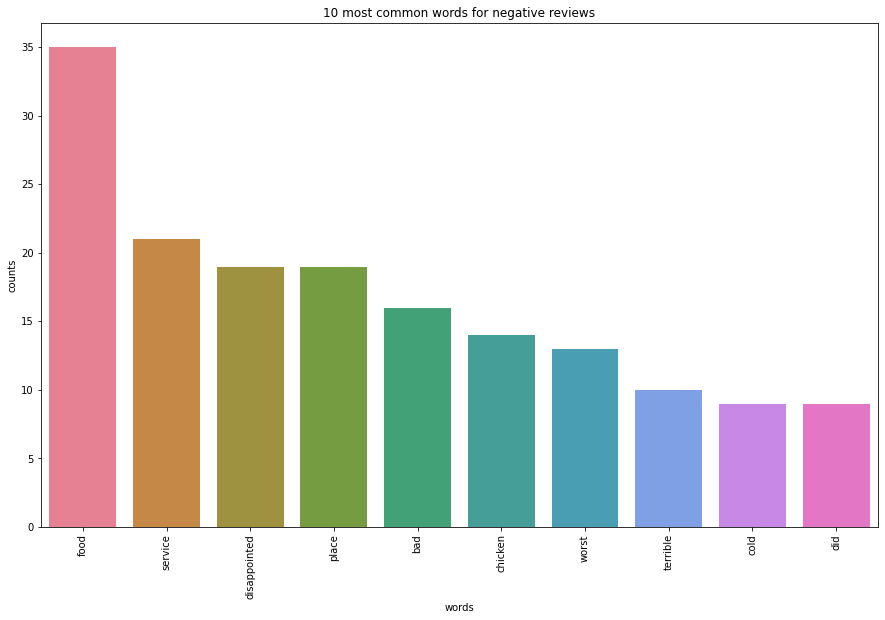

In [7]:
#Sentiment Analysis for Negative Reviews

def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words for negative reviews')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(negative_reviews['Comments'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

Words like food,service, place and chicken are freqeuent words in negative reviews but on their own they are not very informative about the sentiment of negative reviews. Hence, we will look to remove these words before plotting our word cloud.

In [8]:
# Let's use the stop_words argument to remove words like "and, the, a"

stopwords = set(stopwords.words('english'))
cvec = CountVectorizer(min_df = 2, stop_words= stopwords, max_features = 1000)
cvec.fit(negative_reviews['Comments'])

# Transforming using our fitted cvec and converting the result to a DataFrame

negative_words = pd.DataFrame(cvec.transform(negative_reviews['Comments']).todense(),
                       columns=cvec.get_feature_names())

negative_top = negative_words.sum(axis = 0).sort_values(ascending = False).head(150)
negative_pd = pd.DataFrame(data=negative_top)
negative_top = negative_words[negative_pd.index]
negative_top.drop(columns=['food','service', 'place','chicken','back','really','time'], inplace = True)
negative_top.head(15)

C:\Users\sana\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,disappointed,bad,worst,terrible,slow,like,cold,salad,ever,also,...,hard,order,high,hit,ok,needless,hour,husband,immediately,job
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


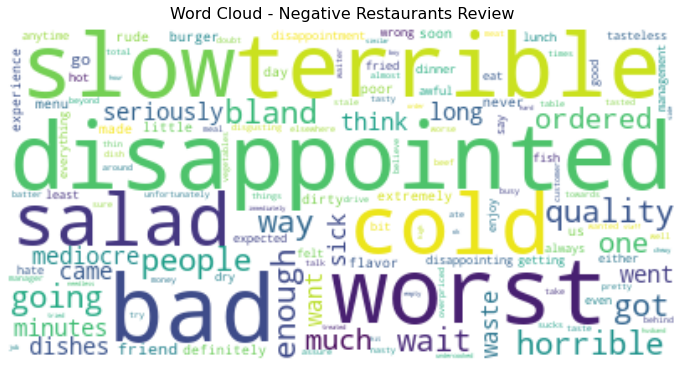

In [9]:
# Generate Word Cloud
from wordcloud import WordCloud
import stylecloud

wordcloud_low = WordCloud(background_color="white").generate(' '.join(negative_top))
plt.figure(figsize = (12,10))
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.title('Word Cloud - Negative Restaurants Review', fontsize=16, y=1.01)
plt.axis("off");

In [10]:
negative_reviews['counter'] = 1
negative_reviews.head()

,Unnamed: 0,User ID,City,User Longitude,User Latitude,Resturant Name,Resturant Longitude,Resturant Latitude,Categories,Special Diets,Review Score,Comments,counter
13,13,293,Eastern Province,54.358230,23.509115,Queen Of India,50.179829,26.328298,Indian,"Vegetarian Friendly, Vegan Options, Gluten Fre...",1.6,"I tried the chicken, with cranberry...mmmm!",1
14,14,69,Jeddah,39.292661,21.385190,Byblos Restaurant,39.129995,21.572716,"Lebanese, Mediterranean, Middle Eastern","Vegetarian Friendly, Vegan Options, Gluten Fre...",1.8,I was disgusted because I was pretty sure that...,1
37,37,18,Riyadh,46.989719,24.657932,Burj Al Hamam,46.681993,24.667666,"Lebanese, Mediterranean, Middle Eastern","Vegetarian Friendly, Vegan Options, Gluten Fre...",1.2,"Poor service, the waiter made me feel like I w...",1
47,47,159,Riyadh,46.617014,24.975343,Al Orjouan,46.630201,24.665121,"Mediterranean, Middle Eastern, International","Vegetarian Friendly, Vegan Options, Gluten Fre...",1.8,It is too bad the food is so damn generic.,1
58,58,475,Eastern Province,51.338183,20.360487,Pattis France,50.120455,26.335141,"French, Cafe, European","Vegetarian Friendly, Vegan Options",1.3,Not much seafood and like 5 strings of pasta a...,1


In [11]:
# Sorting Restaurants based on number of reviews

negative_reviews.groupby('Resturant Name')['counter'].sum().sort_values(ascending = False)

Resturant Name
Queen Of India              14
Byblos Restaurant           12
Abu Nawas                   11
Al Baik                     11
Cafe Bateel                 10
Burj Al Hamam                9
Al Orjouan                   8
Maestro Pizza                7
Al-Sanbok Restaurant         7
Chicken Republic             7
Ginger Leaf                  7
Khayal Restaurant            7
La Brasserie                 7
il Vero                      7
sayadiyah express            7
Lusin                        7
Sura Korean Fine Dining      7
The Blue Restaurant          7
Pattis France                6
Al-Saaj Al-Reefi             6
Steak House                  6
Myazu                        6
Aromi                        5
Manoosha Alreef              5
Sultan Steakhouse Riyadh     4
Tokyo                        4
Wakame                       4
Al Bustan Restaurant         4
Zafran Indian Bistro         4
Tandoori House               4
Taya Restaurant              3
Shawarma House          

In [12]:
# Filtering Reviews from the Worst Restaurant

worst_restaurant_reviews = negative_reviews[negative_reviews['Resturant Name'] == 'Queen Of India']
worst_restaurant_reviews.head(7)

,Unnamed: 0,User ID,City,User Longitude,User Latitude,Resturant Name,Resturant Longitude,Resturant Latitude,Categories,Special Diets,Review Score,Comments,counter
13,13,293,Eastern Province,54.358230,23.509115,Queen Of India,50.179829,26.328298,Indian,"Vegetarian Friendly, Vegan Options, Gluten Fre...",1.6,"I tried the chicken, with cranberry...mmmm!",1
461,461,96,Eastern Province,52.661839,28.838218,Queen Of India,50.179829,26.328298,Indian,"Vegetarian Friendly, Vegan Options, Gluten Fre...",1.9,The last 3 times I had lunch here has been bad,1
536,536,142,Eastern Province,51.416258,28.551505,Queen Of India,50.179829,26.328298,Indian,"Vegetarian Friendly, Vegan Options, Gluten Fre...",1.3,And it was way to expensive,1
569,569,200,Eastern Province,53.241921,24.070885,Queen Of India,50.179829,26.328298,Indian,"Vegetarian Friendly, Vegan Options, Gluten Fre...",1.9,I think this restaurant suffers from not tryin...,1
910,910,493,Eastern Province,54.464339,27.009067,Queen Of India,50.179829,26.328298,Indian,"Vegetarian Friendly, Vegan Options, Gluten Fre...",1.5,After the disappointing dinner we went elsewhe...,1
60,60,428,Eastern Province,52.547826,19.394656,Queen Of India,50.179829,26.328298,Indian,"Vegetarian Friendly, Vegan Options, Gluten Fre...",2.8,"The ripped banana was not only ripped, but pet...",1
141,141,323,Eastern Province,51.209843,25.769755,Queen Of India,50.179829,26.328298,Indian,"Vegetarian Friendly, Vegan Options, Gluten Fre...",2.6,"The service was a little slow , considering th...",1


In [13]:
# Filtering for positive reviews (five star)
pd.set_option("display.max_rows", None)
positive_reviews = df[df['Review Score'] >= 4.5]
print(positive_reviews.shape)
positive_reviews

(286, 12)


,Unnamed: 0,User ID,City,User Longitude,User Latitude,Resturant Name,Resturant Longitude,Resturant Latitude,Categories,Special Diets,Review Score,Comments
1,1,415,Riyadh,46.937884,24.551856,Lusin,46.683451,24.697821,"Mediterranean, Middle Eastern, Armenian","Vegetarian Friendly, Vegan Options, Gluten Fre...",4.6,Crust is not good.
3,3,456,Eastern Province,52.528577,26.575229,Manoosha Alreef,50.118295,26.445350,"Lebanese, Fast Food, Mediterranean, Middle Eas...","Vegetarian Friendly, Vegan Options",4.7,Stopped by during the late May bank holiday of...
4,4,420,Eastern Province,53.446234,26.122919,Queen Of India,50.179829,26.328298,Indian,"Vegetarian Friendly, Vegan Options, Gluten Fre...",4.9,The selection on the menu was great and so wer...
18,18,52,Riyadh,46.735447,24.928060,Shawarma House,46.656787,24.756353,"Fast Food, Middle Eastern",Vegetarian Friendly,5.0,This place is not worth your time
19,19,485,Eastern Province,53.549086,23.763164,Hamra Chicken,50.204263,26.290657,"Lebanese, Fast Food, Mediterranean, Middle Eas...",Non,4.5,did not like at all.
22,22,335,Jeddah,39.130564,21.879091,Aromi,39.109269,21.603596,"Italian, Mediterranean, European","Vegetarian Friendly, Vegan Options, Gluten Fre...",4.8,Service is also cute.
23,23,371,Riyadh,46.590949,24.800925,Tokyo,46.686664,24.718261,"Japanese, Sushi, Asian","Vegetarian Friendly, Vegan Options, Gluten Fre...",4.7,I like it
24,24,144,Eastern Province,52.739975,25.996453,Manoosha Alreef,50.118295,26.445350,"Lebanese, Fast Food, Mediterranean, Middle Eas...","Vegetarian Friendly, Vegan Options",4.5,I could care less... The interior is just beau...
25,25,355,Jeddah,39.165971,21.507367,sayadiyah express,39.177457,21.527526,Seafood,Non,4.5,So they performed.
26,26,376,Jeddah,39.184589,21.007776,Sura Korean Fine Dining,39.153422,21.558961,"Asian, Korean","Vegetarian Friendly, Vegan Options",4.8,That is right....the red velvet cake.....ohhh ...


C:\Users\sana\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


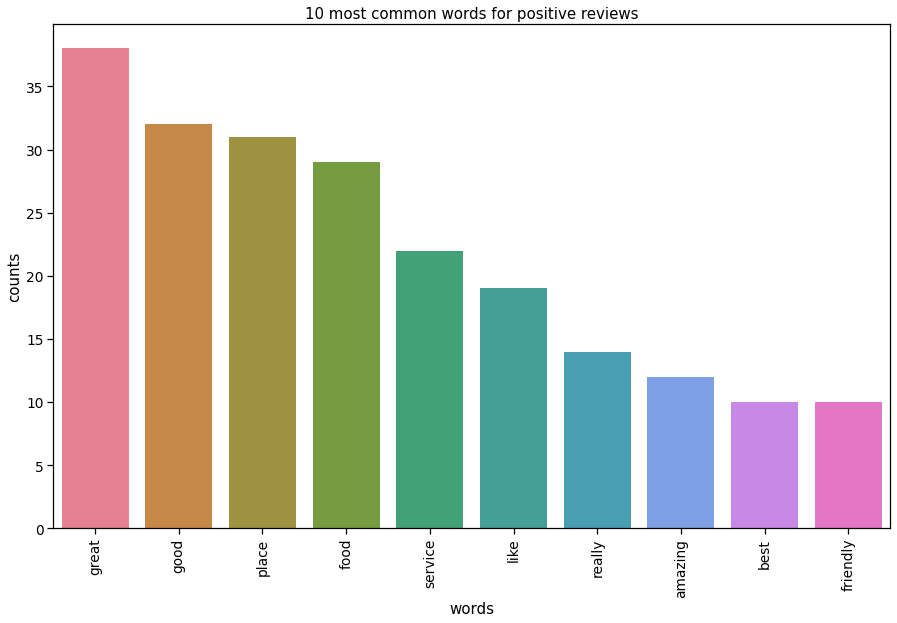

In [14]:
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words for positive reviews')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

## Sentiment Analysis for high rated reviews
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(positive_reviews['Comments'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [15]:
# Let's use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(min_df = 2, stop_words= stopwords, max_features = 1000)

cvec.fit(positive_reviews['Comments'])

positive_words = pd.DataFrame(cvec.transform(positive_reviews['Comments']).todense(),
                       columns=cvec.get_feature_names())

positive_top = positive_words.sum(axis = 0).sort_values(ascending = False).head(100)
positive_pd = pd.DataFrame(data=positive_top)
positive_top = positive_words[positive_pd.index]
positive_top.drop(columns=['place','eat', 'inside','food','night','really','time','back','never','restaurant','service'], inplace = True)
positive_top.head()

C:\Users\sana\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,great,good,like,amazing,go,friendly,best,would,get,nice,...,folks,enough,breakfast,since,still,dishes,buffet,spot,say,perfectly
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


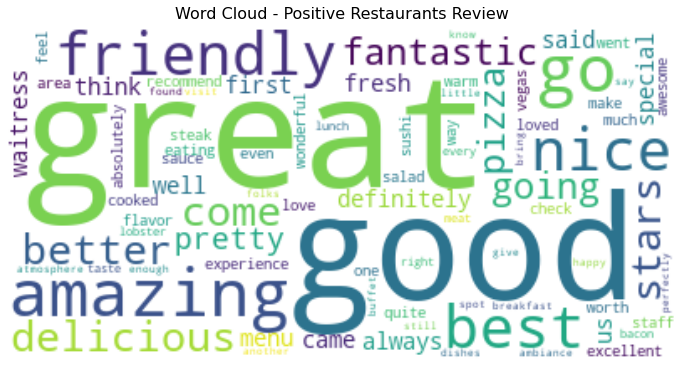

In [16]:
# Generate Word Cloud

wordcloud_high = WordCloud(background_color="white").generate(' '.join(positive_top))
plt.figure(figsize = (12,10))
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.title('Word Cloud - Positive Restaurants Review', fontsize=16, y=1.01)
plt.axis("off");

In [17]:
positive_reviews['counter'] = 1
positive_reviews.head()

<ipython-input-17-d84df0d730bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_reviews['counter'] = 1


,Unnamed: 0,User ID,City,User Longitude,User Latitude,Resturant Name,Resturant Longitude,Resturant Latitude,Categories,Special Diets,Review Score,Comments,counter
1,1,415,Riyadh,46.937884,24.551856,Lusin,46.683451,24.697821,"Mediterranean, Middle Eastern, Armenian","Vegetarian Friendly, Vegan Options, Gluten Fre...",4.6,Crust is not good.,1
3,3,456,Eastern Province,52.528577,26.575229,Manoosha Alreef,50.118295,26.445350,"Lebanese, Fast Food, Mediterranean, Middle Eas...","Vegetarian Friendly, Vegan Options",4.7,Stopped by during the late May bank holiday of...,1
4,4,420,Eastern Province,53.446234,26.122919,Queen Of India,50.179829,26.328298,Indian,"Vegetarian Friendly, Vegan Options, Gluten Fre...",4.9,The selection on the menu was great and so wer...,1
18,18,52,Riyadh,46.735447,24.928060,Shawarma House,46.656787,24.756353,"Fast Food, Middle Eastern",Vegetarian Friendly,5.0,This place is not worth your time,1
19,19,485,Eastern Province,53.549086,23.763164,Hamra Chicken,50.204263,26.290657,"Lebanese, Fast Food, Mediterranean, Middle Eas...",Non,4.5,did not like at all.,1


In [18]:
# Sorting Restaurants Based on Most Reviews

positive_reviews.groupby('Resturant Name')['counter'].sum().sort_values(ascending = False)

Resturant Name
Tandoori House              15
Taya Restaurant             14
Lotus                       14
sayadiyah express           13
Maestro Pizza               12
Al-Sanbok Restaurant        11
Manoosha Alreef             11
Queen Of India              10
Myazu                       10
Al Baik                      9
Al Bustan Restaurant         9
Cafe Bateel                  9
Ginger Leaf                  9
Hamra Chicken                9
Khayal Restaurant            9
il Vero                      9
Abu Nawas                    9
Tokyo                        9
Pattis France                8
Wakame                       8
Lusin                        8
Steak House                  8
La Brasserie                 8
Sura Korean Fine Dining      7
Aromi                        7
Sultan Steakhouse Riyadh     6
Shawarma House               6
Burj Al Hamam                6
Al Orjouan                   6
Byblos Restaurant            6
Al-Saaj Al-Reefi             4
The Blue Restaurant     

In [19]:
# Restaurant with most positive reviews

best_restaurant = df[df['Resturant Name'] == 'Tandoori House']
best_restaurant.head(4)

,Unnamed: 0,User ID,City,User Longitude,User Latitude,Resturant Name,Resturant Longitude,Resturant Latitude,Categories,Special Diets,Review Score,Comments
28,28,338,Eastern Province,49.758107,22.937311,Tandoori House,50.129764,26.30379,Indian,Non,4.7,"This has great Mexican street tacos, and frien..."
187,187,42,Eastern Province,50.684184,25.057620,Tandoori House,50.129764,26.30379,Indian,Non,3.0,"When my order arrived, one of the gyros was mi..."
255,255,41,Eastern Province,49.535369,24.739772,Tandoori House,50.129764,26.30379,Indian,Non,1.2,very tough and very short on flavor!
272,272,458,Eastern Province,51.229313,25.172638,Tandoori House,50.129764,26.30379,Indian,Non,4.6,I liked the patio and the service was outstanding


## Sentiment Analysis

In [20]:
# Import Textblob

from textblob import Word

# Splitting up words in reviews

df['cleaned_text'] = df['Comments'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Remove Punctuation

df['cleaned_text'] = df['Comments'].str.replace('[^\w\s]', '')

# Remove Stopwords

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))

# Lemmatizing cleaned text

df['cleaned_text'] = df['cleaned_text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df.head()

,Unnamed: 0,User ID,City,User Longitude,User Latitude,Resturant Name,Resturant Longitude,Resturant Latitude,Categories,Special Diets,Review Score,Comments,cleaned_text
0,0,317,Jeddah,39.218564,21.736983,Al-Saaj Al-Reefi,39.137253,21.621797,"Fast Food, Middle Eastern, Lebanese, Mediterra...",Non,4.0,Wow... Loved this place,Wow Loved place
1,1,415,Riyadh,46.937884,24.551856,Lusin,46.683451,24.697821,"Mediterranean, Middle Eastern, Armenian","Vegetarian Friendly, Vegan Options, Gluten Fre...",4.6,Crust is not good.,Crust good
2,2,425,Riyadh,46.501978,24.699156,La Brasserie,46.684105,24.690431,"French, International","Vegetarian Friendly, Vegan Options",2.7,Not tasty and the texture was just nasty.,Not tasty texture nasty
3,3,456,Eastern Province,52.528577,26.575229,Manoosha Alreef,50.118295,26.445350,"Lebanese, Fast Food, Mediterranean, Middle Eas...","Vegetarian Friendly, Vegan Options",4.7,Stopped by during the late May bank holiday of...,Stopped late May bank holiday Rick Steve recom...
4,4,420,Eastern Province,53.446234,26.122919,Queen Of India,50.179829,26.328298,Indian,"Vegetarian Friendly, Vegan Options, Gluten Fre...",4.9,The selection on the menu was great and so wer...,The selection menu great price


The sentiment function of textblob returns two properties, polarity, and subjectivity.

Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

In [21]:
# Calculate polarity and subjectivity score

from textblob import TextBlob

df['polarity'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment[0])
df['subjectivity'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment[1])
df.head(3)

,Unnamed: 0,User ID,City,User Longitude,User Latitude,Resturant Name,Resturant Longitude,Resturant Latitude,Categories,Special Diets,Review Score,Comments,cleaned_text,polarity,subjectivity
0,0,317,Jeddah,39.218564,21.736983,Al-Saaj Al-Reefi,39.137253,21.621797,"Fast Food, Middle Eastern, Lebanese, Mediterra...",Non,4.0,Wow... Loved this place,Wow Loved place,0.4,0.9
1,1,415,Riyadh,46.937884,24.551856,Lusin,46.683451,24.697821,"Mediterranean, Middle Eastern, Armenian","Vegetarian Friendly, Vegan Options, Gluten Fre...",4.6,Crust is not good.,Crust good,0.7,0.6
2,2,425,Riyadh,46.501978,24.699156,La Brasserie,46.684105,24.690431,"French, International","Vegetarian Friendly, Vegan Options",2.7,Not tasty and the texture was just nasty.,Not tasty texture nasty,-1.0,1.0


VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool used for sentiment analysis of text which has both the polarities i.e. positive/negative. VADER is used to quantify how much of positive or negative emotion the text has and also the intensity of emotion.

In [22]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sana\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [23]:
sentiment= SentimentIntensityAnalyzer()

### Example:

In [24]:
sentences=["This is a great resturant"]
for sentence in sentences:
    s = sentiment.polarity_scores(sentence) 
s

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [25]:
sentences1=["This is a GREAT resturant"]
for sentence in sentences1:
    e = sentiment.polarity_scores(sentence) 
e

{'neg': 0.0, 'neu': 0.383, 'pos': 0.617, 'compound': 0.7034}

In [26]:
sentences2=["This is a GREAT resturant :)"]
for sentence in sentences2:
    n = sentiment.polarity_scores(sentence) 
n

{'neg': 0.0, 'neu': 0.277, 'pos': 0.723, 'compound': 0.8331}

In [27]:
# Calculate Vader Sentiment Analysis Scores

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

sentiment = df['Comments'].apply(lambda x: analyzer.polarity_scores(x))
df = pd.concat([df,sentiment.apply(pd.Series)],1)
df.sample(5)

,Unnamed: 0,User ID,City,User Longitude,User Latitude,Resturant Name,Resturant Longitude,Resturant Latitude,Categories,Special Diets,Review Score,Comments,cleaned_text,polarity,subjectivity,neg,neu,pos,compound
193,193,235,Riyadh,46.634067,24.921803,Zafran Indian Bistro,46.624899,24.752996,"Indian, Healthy, Soups, Grill","Vegetarian Friendly, Vegan Options, Gluten Fre...",3.6,Very friendly staff.,Very friendly staff,0.4875,0.650,0.000,0.364,0.636,0.5413
146,146,490,Riyadh,46.527724,24.716503,La Brasserie,46.684105,24.690431,"French, International","Vegetarian Friendly, Vegan Options",4.1,We waited for forty five minutes in vain.,We waited forty five minute vain,0.0000,0.000,0.286,0.714,0.000,-0.4215
755,755,301,Eastern Province,47.932647,19.443016,il Vero,50.177963,26.367068,"Italian, Romana, Lazio, Central-Italian, Pizza","Vegetarian Friendly, Vegan Options, Gluten Fre...",3.8,"I have watched their prices inflate, portions ...",I watched price inflate portion get smaller ma...,0.0000,0.500,0.000,1.000,0.000,0.0000
436,436,298,Eastern Province,50.625531,27.408022,Pattis France,50.120455,26.335141,"French, Cafe, European","Vegetarian Friendly, Vegan Options",4.0,I never come again,I never come,0.0000,0.000,0.000,1.000,0.000,0.0000
896,896,260,Eastern Province,50.304344,25.282891,il Vero,50.177963,26.367068,"Italian, Romana, Lazio, Central-Italian, Pizza","Vegetarian Friendly, Vegan Options, Gluten Fre...",2.4,My boyfriend tried the Mediterranean Chicken S...,My boyfriend tried Mediterranean Chicken Salad...,-0.0500,0.775,0.000,0.704,0.296,0.6369


The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive). The more Compound score closer to +1, the higher the positivity of the text.

C:\Users\sana\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Percentage of Restaurants')

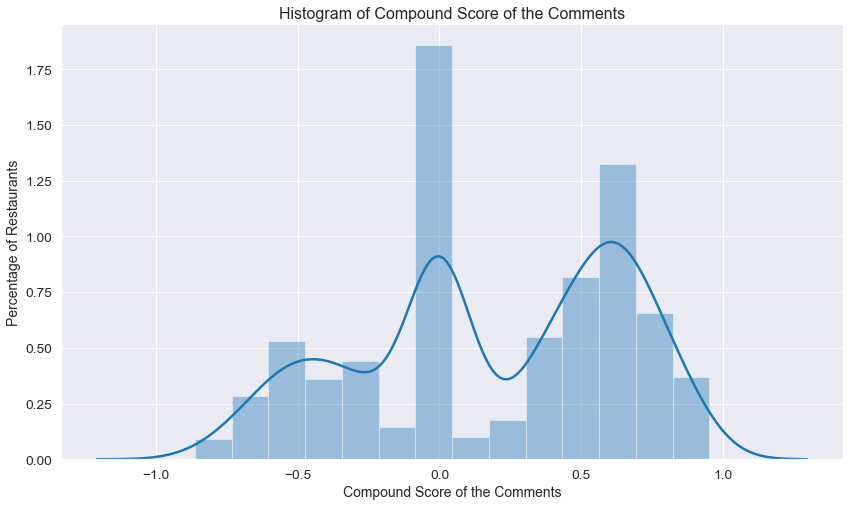

In [28]:
# Histogram of Compound Score 

sns.set_style("darkgrid")
plt.figure(figsize=(14,8))
sns.distplot(df['compound'])
plt.title('Histogram of Compound Score of the Comments', fontsize = 16)
plt.xlabel('Compound Score of the Comments', fontsize=14)
plt.ylabel('Percentage of Restaurants', fontsize=14)

Remember that high subjectivity refers that mostly it is a public opinion and not a factual information.

In [29]:
positive=0
negative=0
neutral=0
for i in range(df.shape[0]):
    if df['polarity'][i]>0:
        positive=positive+1
    elif df['polarity'][i]<0:
        negative=negative+1
    else: 
        neutral=neutral+1

In [30]:
positive

522

In [31]:
negative


229

In [32]:
neutral

249

C:\Users\sana\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


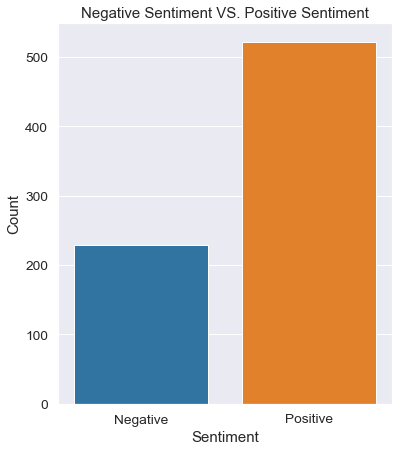

In [33]:
plt.figure(figsize=(6,7))
x = ['Negative', 'Positive']
y = [229,522]

sns.barplot(x, y)
plt.title('Negative Sentiment VS. Positive Sentiment')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

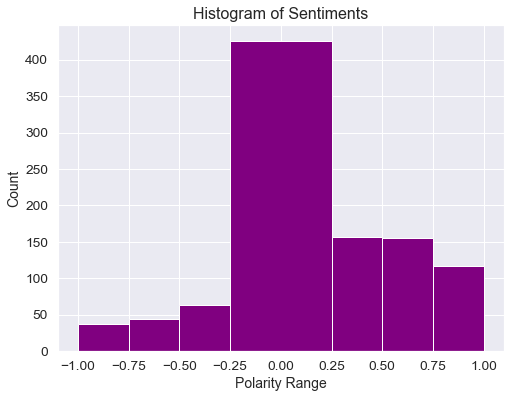

In [34]:
fig, ax= plt.subplots(figsize=(8,6))
sns.set_style("whitegrid")
df['polarity'].hist(bins=[-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1],ax=ax,color='purple')
plt.title('Histogram of Sentiments', fontsize = 16)
plt.xlabel('Polarity Range', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()
#px.histogram(
 #       df, 
  #      x="Review Score",
   #     color = 'Special Diets'
    #    )
#histo.show()


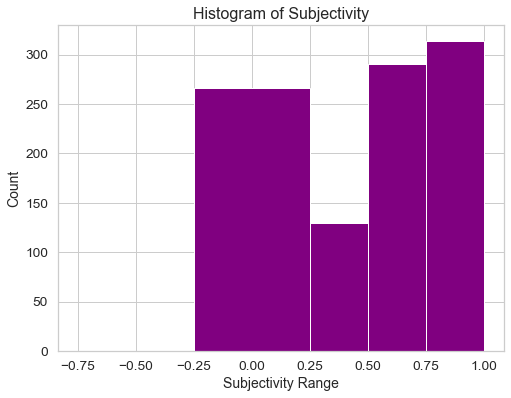

In [35]:
fig, ax= plt.subplots(figsize=(8,6))
df['subjectivity'].hist(bins=[-0.75,-0.5,-0.25,0.25,0.5,0.75,1],ax=ax,color='purple')
plt.title('Histogram of Subjectivity', fontsize = 16)
plt.xlabel('Subjectivity Range', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()